![IE](../img/ie.png)

# Extra: Big Data Science in Python with Dask

### Juan Luis Cano Rodríguez <jcano@faculty.ie.edu> - Master in Business Analytics and Big Data (2021-02-25)

## Larger than RAM `DataFrame`s 

A decade ago, **pandas** brought a revolution by enabling Python users to perform data analysis and manipulation in desktop computers and laptops. However, by that time CPU speed evolution had already slowed down dramatically, and technologies like Hadoop had appeared to enable manipulation of massive datasets ("Big Data").

![Clock speeds](../img/clock.jpg)

Which means that, most of the time, our Python processing scripts are doing something like this:

![CPUs](../img/cpus.gif)

Essentially two axis of improvement exist to accelerate the performance of data analysis pipelines:

1. **Scale up**: Better machines, faster CPUs. Incremental progress over the latest years, but no longer exponential growth (Moore's law)
2. **Scale out**: More machines, parallel processing, GPUs, TPUs. More complexity in heterogeneous setups, not all tasks can be easily parallelized.

![Scale](../img/scale.png)

The ecosystem of solutions that try to improve data analysis workflows in Python is vast, both for scaling up and scaling out. In this session we will study Dask, a Python library and ecosystem that leverages existing APIs (NumPy, pandas) and extends them to support parallel computing.

# Dask

<img src="../img/dask.svg" width="300px" />

From the documentation:

> Dask is a flexible library for parallel computing in Python.
>
> Dask emphasizes the following virtues:
> 
> - **Familiar**: Provides parallelized NumPy array and Pandas DataFrame objects
> - **Flexible**: Provides a task scheduling interface for more custom workloads and integration with other projects.
> - **Native**: Enables distributed computing in pure Python with access to the PyData stack.
> - **Fast**: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
> - **Scales up**: Runs resiliently on clusters with 1000s of cores
> - **Scales down**: Trivial to set up and run on a laptop in a single process
> - **Responsive**: Designed with interactive computing in mind, it provides rapid feedback and diagnostics to aid humans

![Dask overview](../img/dask-overview.svg)

## Installation

Installation is trivially simple. With conda:

```
$ conda install dask
```

or, alternatively, with pip:

```
$ pip install dask[complete]
```

## Lazy evaluation

Let's do a simple example with `dask.array` to understand how lazy evaluation works.

In [1]:
import numpy as np
import dask.array as da

In [2]:
x = np.arange(1000)
y = da.from_array(x, chunks=100)

In [3]:
x[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

While x is a familiar NumPy array, y is a distinct object:

In [4]:
y

dask.array<array, shape=(1000,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [5]:
y.dask

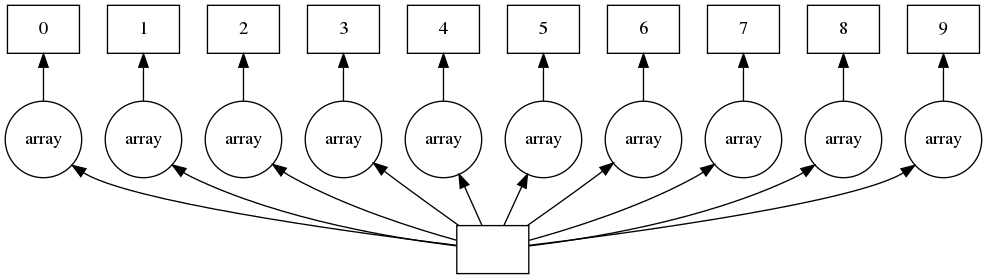

In [6]:
y.visualize()

If we try to perform any operation on this array, it does not execute immediately:

In [7]:
x.mean()

499.5

In [8]:
y.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

Instead, Dask builds a task graph with all the necessary operations and its dependencies so we can visualize it and reason about it. This graph is stored in common Python data structures like dicts, lists, tuples and arrays, and we can visualize it:

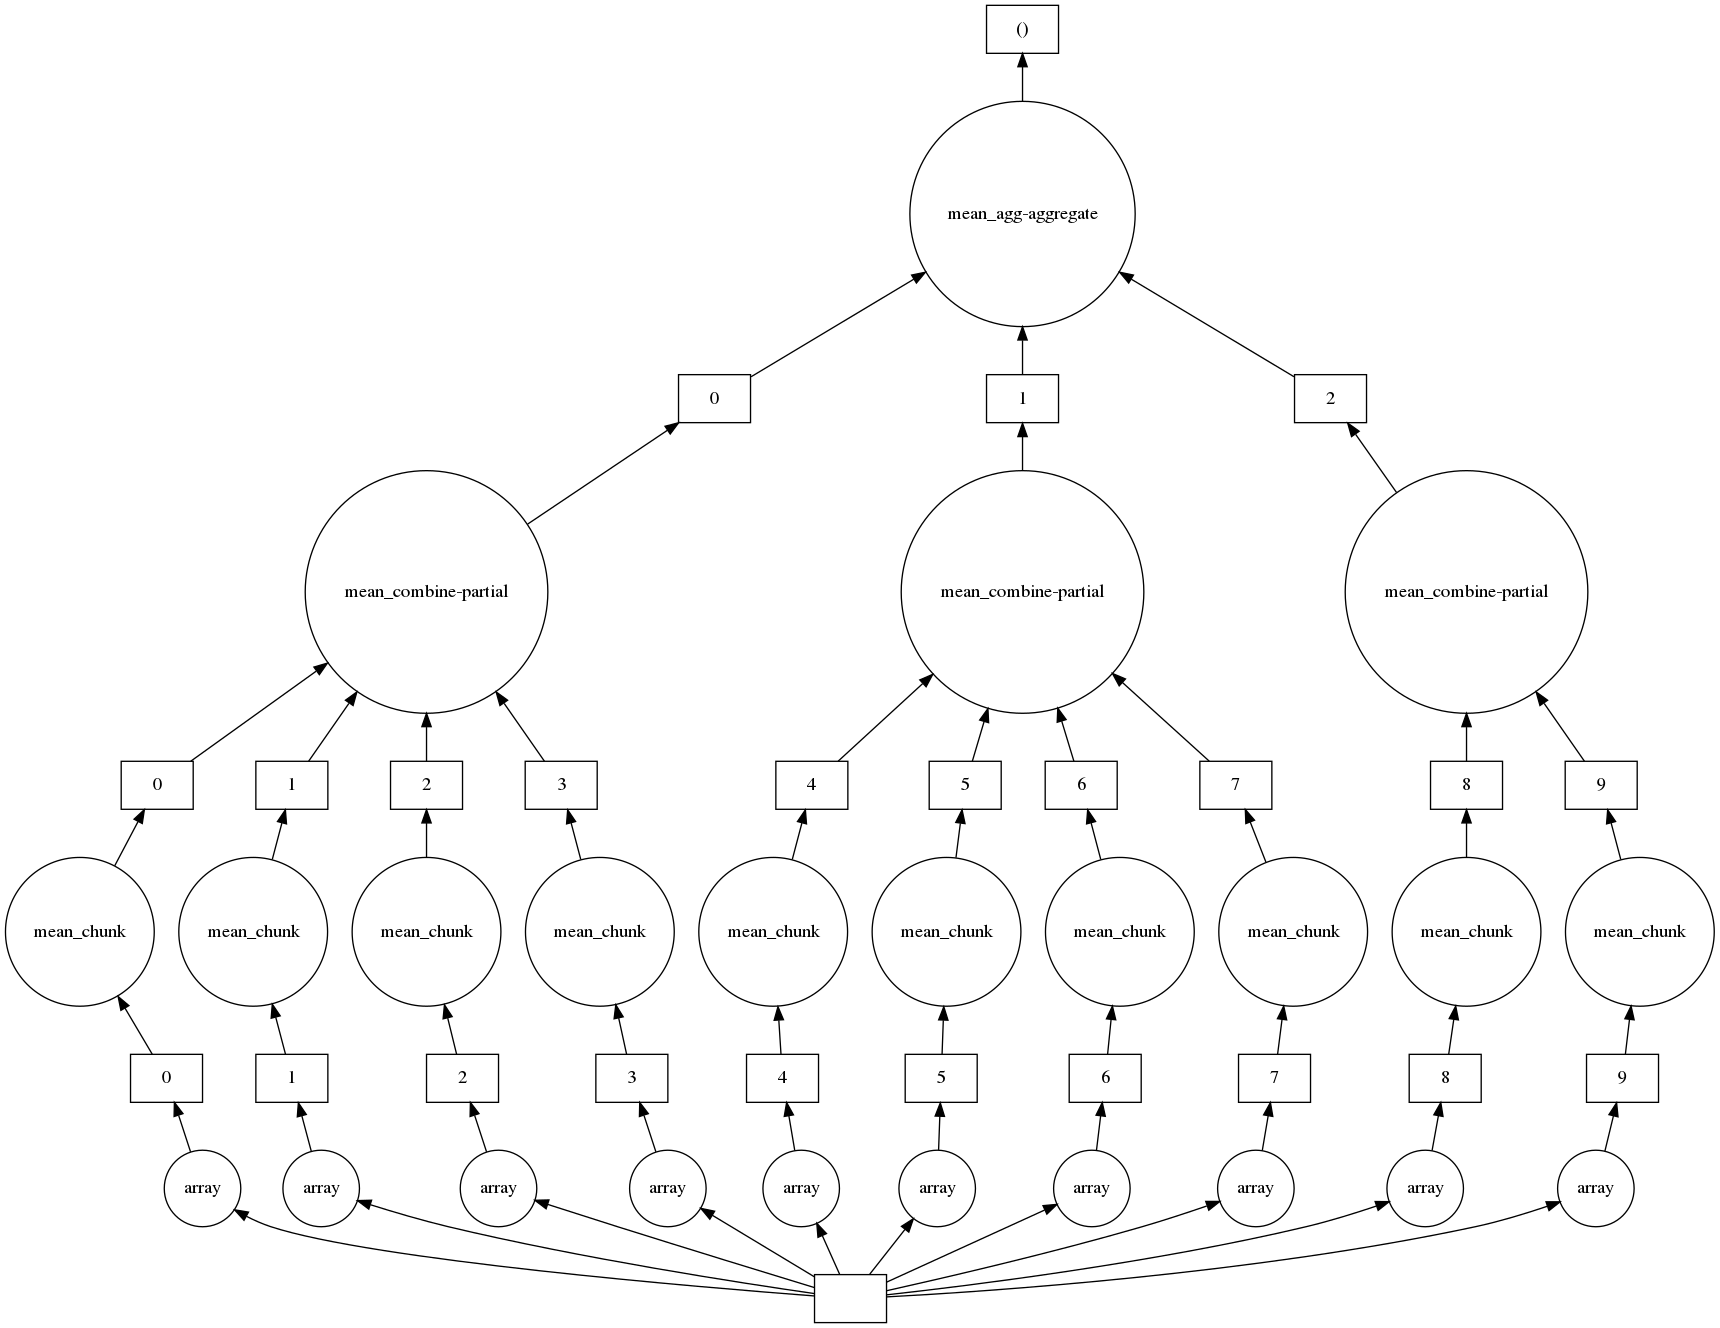

In [9]:
y.mean().visualize()

If we want to actually perform the operation, we need to call `.compute()`:

In [10]:
y.mean().compute()

499.5

Which is the same API we use to transform our Dask array into a normal NumPy array:

In [11]:
y.compute()[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Demo: NYC taxis

Apart from `dask.array` mimicking the NumPy API, we also have `dask.dataframe` that behaves like pandas DataFrames.

<img src="../img/dask-dataframe.svg" width="300px" />

To study how do they work, we will use a subset of the NYC taxi dataset:

```
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv
```

(see https://github.com/toddwschneider/nyc-taxi-data for more info)

## Prerequisites

These will be the packages we will need:

```
$ conda install dask python-graphviz ipywidgets notebook
```

<div class="alert alert-warning">Beware! <a href="https://github.com/dask/distributed/issues/3905">Dask 2.18.1 is incompatible with 2.1.0</a>.</div>

## Getting started

In [12]:
!du ../data/yellow*.csv -h -s

656M	../data/yellow_tripdata_2019-01.csv
620M	../data/yellow_tripdata_2019-02.csv


In [13]:
payment_types = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

In [14]:
import dask.dataframe as dd

In [15]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:45981 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.70 GB


In [16]:
!head ../data/yellow_tripdata_2019-01.csv

We can load the data with `dask.dataframe.read_csv`, which has a similar API to `pandas.read_csv`. It accepts a filename filter to load several filenames at the same time:

In [17]:
df = dd.read_csv(
    "../data/yellow_tripdata_2019-*.csv",
    parse_dates=[
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime"
    ]
)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=22,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [18]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [19]:
# This will take a while, open the dashboard in the meanwhile!
len(df)

14687167

We can use `client.submit` to asynchronously submit computations to the Dask scheduler:

In [20]:
# This won't block the interpreter!
futures = client.submit(len, df)  # Internally this will do len(df)
futures

<Future: pending, key: len-9cf6cd122e86c56c732a23e0c10f1760>

In [21]:
futures

<Future: finished, type: builtins.int, key: len-9cf6cd122e86c56c732a23e0c10f1760>

In [22]:
futures.result()

14687167

In [23]:
op = df.groupby("passenger_count")["trip_distance"].mean()
op

Dask Series Structure:
npartitions=1
    float64
        ...
Name: trip_distance, dtype: float64
Dask Name: truediv, 119 tasks

For computations that are already lazy, we can use `client.compute` as an alternative to the `.compute()` method:

In [24]:
# Asynchronous alternative to op.compute()
futures = client.compute(op)
futures

<Future: pending, key: finalize-dacc09af3e4bdad413e2f085ed746361>

In [25]:
from distributed import progress

In [26]:
progress(futures)

VBox()

In [27]:
futures.result()

passenger_count
0    2.718491
1    2.822670
2    2.915530
3    2.868832
4    2.881076
5    2.886568
6    2.853975
7    2.695510
8    3.781228
9    3.251739
Name: trip_distance, dtype: float64

And this operation will be more complex than the previous ones:

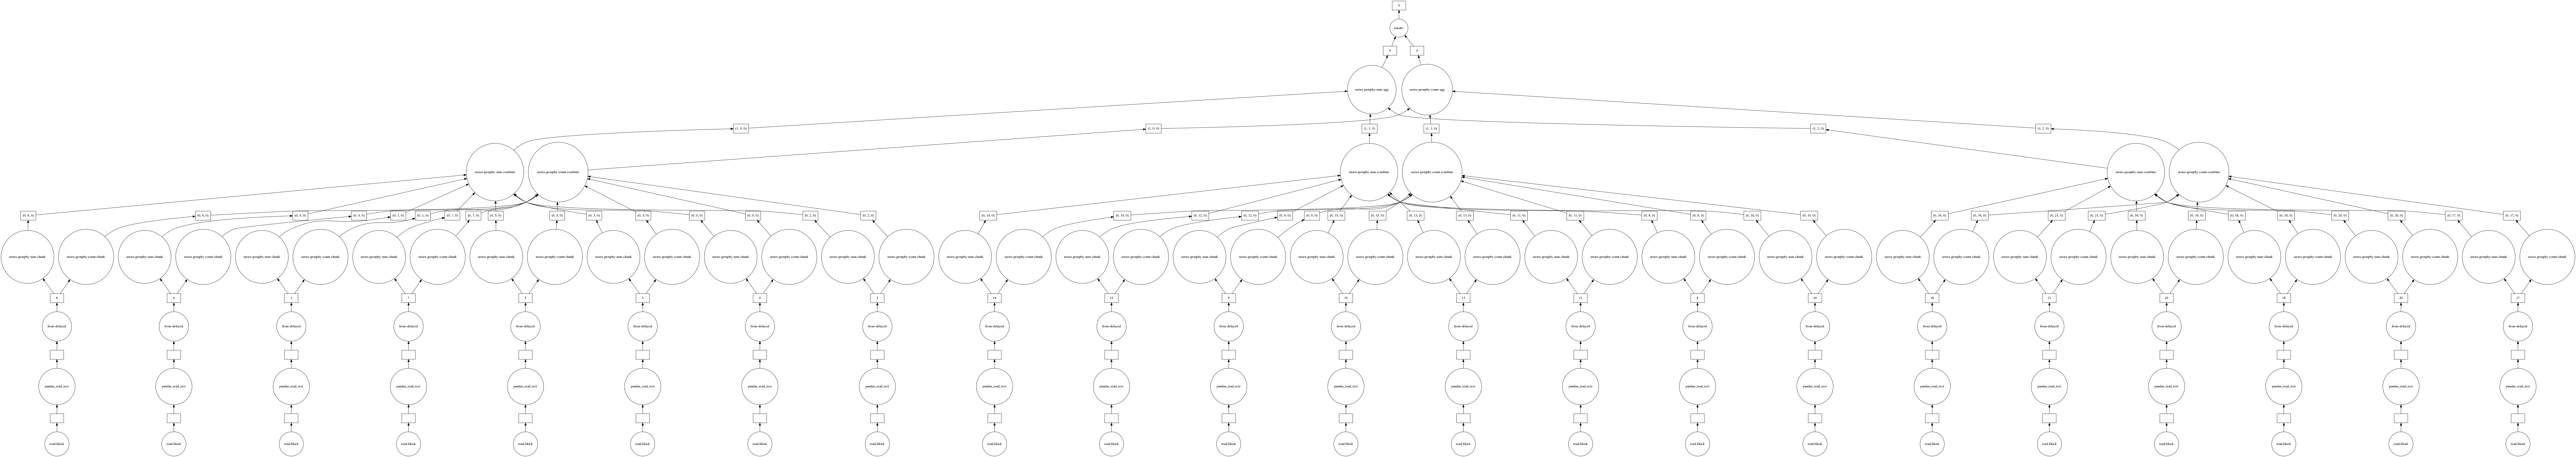

In [28]:
op.visualize()

## Limitations

Let's investigate the distribution of tip amounts with respect to payment types:

What does this warning mean? In Dask, some operations are partition-sensitive https://docs.dask.org/en/latest/dataframe-design.html#partitions. Some of them will give us a warning, and some others will fail directly:

<div class="alert alert-danger">This will load all the data in RAM! Do not run it if you are in a constrained environment</div>

In [ ]:
# daily_mean.compute()

### Exercise

1. Create a new dataframe `df3` using only the rows of `df` with values of `tip_amount` and `fare_amount` greater than zero
2. Create a new `tip_fraction` column in `df2` with the tip amount divided by the fare amount
3. Group the dataframe by pickup hour, and compute the mean `tip_fraction` by pickup hour
4. Visualize the mean `tip_fraction` by pickup hour in a line plot
5. Compute and visualize the mean `tip_fraction` by day of the week